# Tour du Mont-Blanc trekking

Facing new challenges is always a good thing. And they can be of any type.

This summer, I decided to go hiking around the Mont Blanc (highest montain in Europe). Short context:

- we hiked 9 days
- we were a group of 3 people
- we were carrying a tent and used it every night for sleeping
- we did approximately 160 km in total

I had different goals for this trekking:

1. For personal reasons, this is something I've wanted to do for about a year
2. Track GPS data and write some kind of report with numbers and graphs
3. Face a new challenge to push my physical and motivation limits further

While I was preparing the Tour du Mont-Blanc (TMB) beforehand, I had quite a hard time finding good information about the different days. Sure there are **plenty** of blog posts from other trekkers, books and guides giving useful advice. But what I really wanted was a good online resource showing kilometers, elevation and times for all the different parts of the track. And I couln't find any!

The purpose of this notebook is to give an overview of our trip from the statictiscal point of view.

## Gear

The GPS data was recorded with a standard Android phone (Nexus 5).

Just before starting the walk, we would just initiate the recording and let the device do its job. Sometimes (although not systemactically), I would place a mark for longer breaks like (lunch).

And that's it for the gear. Of course it is useful to have a spare battery to recharge the phone.

## Visualizing the data

There are several websites online that makes it possible to visualize GPS data. The only thing to do is to upload a GPX file.

A good one is [mapexplorer.com](http://maplorer.com/view_gpx.html). Upload a GPX file to visualize both the trace map and the elevation graph. Quite useful for single tracks, but not practical to in this case when the goal is to do some story telling for a multi-day trip.

With the Jupyter Notebook, it becomes very easy to write and photos while plotting data. Super convenient to tell a story!

## Setup

Let's define some tools and libraries needed to create the statistics and graphs.

In [1]:
import datetime
import folium
import gpxpy
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import qgrid
from collections import defaultdict
from IPython.display import display
from pytz import timezone
from statistics import mean

%matplotlib inline
plt.rcdefaults()
sns.set_style('darkgrid')
sns.set_palette('deep', desat=.6)
sns.set_context(rc={"figure.figsize": (16, 9)})

france = timezone('Europe/Paris')

qgrid.set_defaults(remote_js=True)

`folium` will be used to display the maps, and `gpxpy` to load and manipulate gpx data.

In [2]:
DATA_FOLDER = 'gps_data/'
data_files = [os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER)]

# sort by day
data_files.sort()

Now, let's build a mini framework that will be reused for each day. Doing so, we can minimize the lines of code and focus on the story telling.

To make it simpler, let's load all the data at once.

In [3]:
day_points = []
stats = defaultdict(list)

for file in data_files:
    with open(file, 'r') as f:
        gpx = gpxpy.parse(f)
        
    points = gpx.get_points_data()
    day_points.append({
        'points': points,
        'waypoints': gpx.waypoints
    })
    
    lowest, highest = gpx.get_elevation_extremes()
    uphill, downhill = gpx.get_uphill_downhill()
    stats['Date'].append(gpx.get_time_bounds().start_time)
    stats['Distance'].append(points[-1].distance_from_start / 1000)
    stats['Duration'].append(str(datetime.timedelta(seconds=gpx.get_duration())))
    stats['Lowest'].append(int(lowest))
    stats['Highest'].append(int(highest))
    stats['Uphill'].append(int(uphill))
    stats['Downhill'].append(int(downhill))
    
df = pd.DataFrame(
        stats,
        columns=['Date', 'Distance', 'Duration', 'Lowest', 'Highest', 'Uphill', 'Downhill'],
    )

# reindex by date
df = df.set_index(['Date'])

# custom formatter
df['Distance'] = df['Distance'].map('{:.2f} km'.format)
df['Lowest'] = df['Lowest'].map('{} m'.format)
df['Highest'] = df['Highest'].map('{} m'.format)
df['Uphill'] = df['Uphill'].map('{} m'.format)
df['Downhill'] = df['Downhill'].map('{} m'.format)

Then, given a set of points, plot them on a map.

In [4]:
def plot_track(points, waypoints):
    points = [p.point for p in points]
    mean_lat = mean(p.latitude for p in points)
    mean_lng = mean(p.longitude for p in points)
    
    # create the map
    m = folium.Map(location=[mean_lat, mean_lng], zoom_start=13)
    
    pts = [tuple([p.latitude, p.longitude]) for p in points]
    folium.PolyLine(pts, color='red', weight=2.5, opacity=1).add_to(m)
    
    # sometimes, there are some markers to indicate breaks, lunch or rest
    for p in waypoints:
        marker = folium.Marker(tuple([p.latitude, p.longitude]), popup=p.name.strip())
        marker.add_to(m)
    
    display(m)

Given a set of points, plot the elevation over the distance.

In [5]:
def plot_elevation(points, waypoints):
    px = [p.distance_from_start / 1000 for p in points]
    py = [p.point.elevation for p in points]
    plt.plot(px, py)
    plt.xlabel('Distance (km)')
    plt.ylabel('Elevation (m)')
    plt.show()

Given a day, show its statistics.

In [6]:
def plot_day(day):
    points = day_points[day - 1]['points']
    wps = day_points[day - 1]['waypoints']
    display(qgrid.show_grid(df[day-1:day]))
    plot_track(points, wps)
    plot_elevation(points, wps)

Once the tools are setup, it is time for the trip!

## Day 1: Les Houches - Chalets de Miage

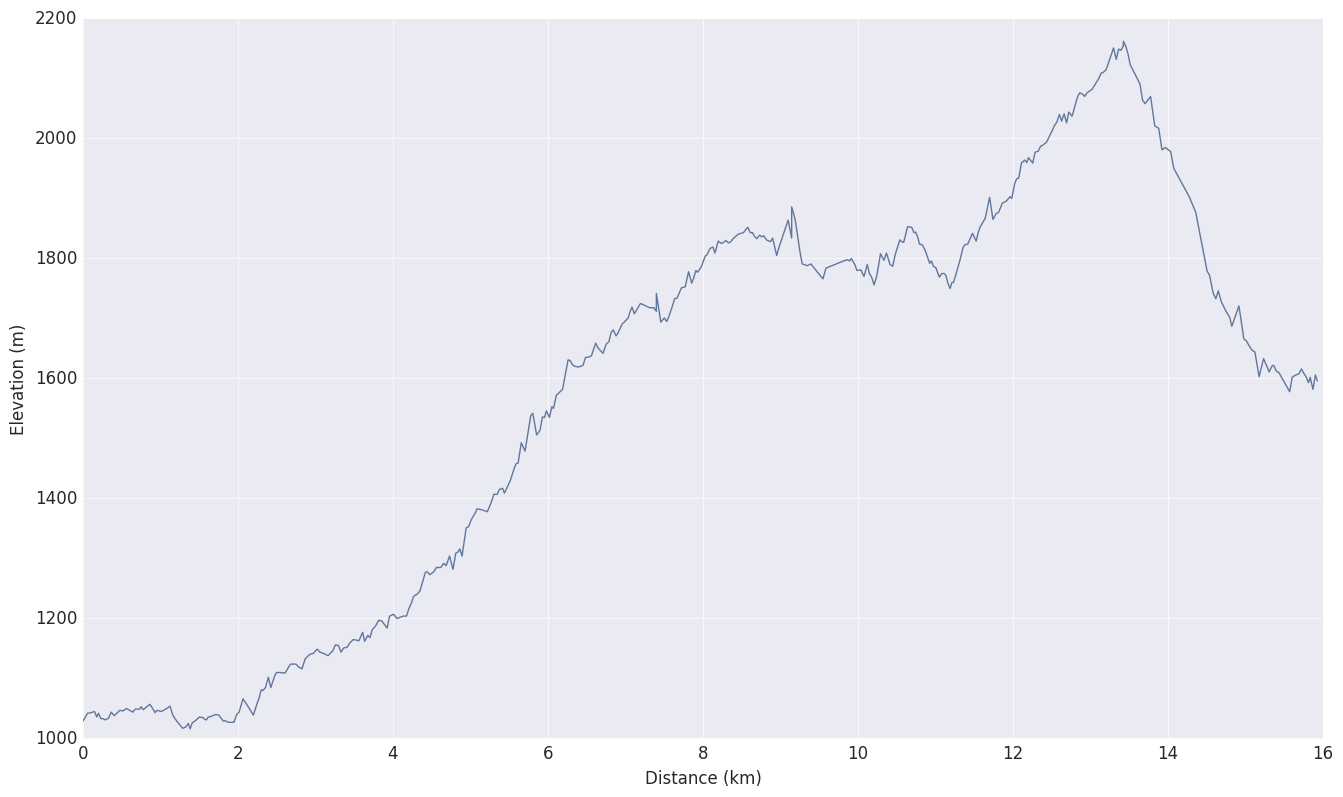

In [7]:
plot_day(1)

## Day 2: Chalets de Miage - Refuge de la Croix de Bonhomme

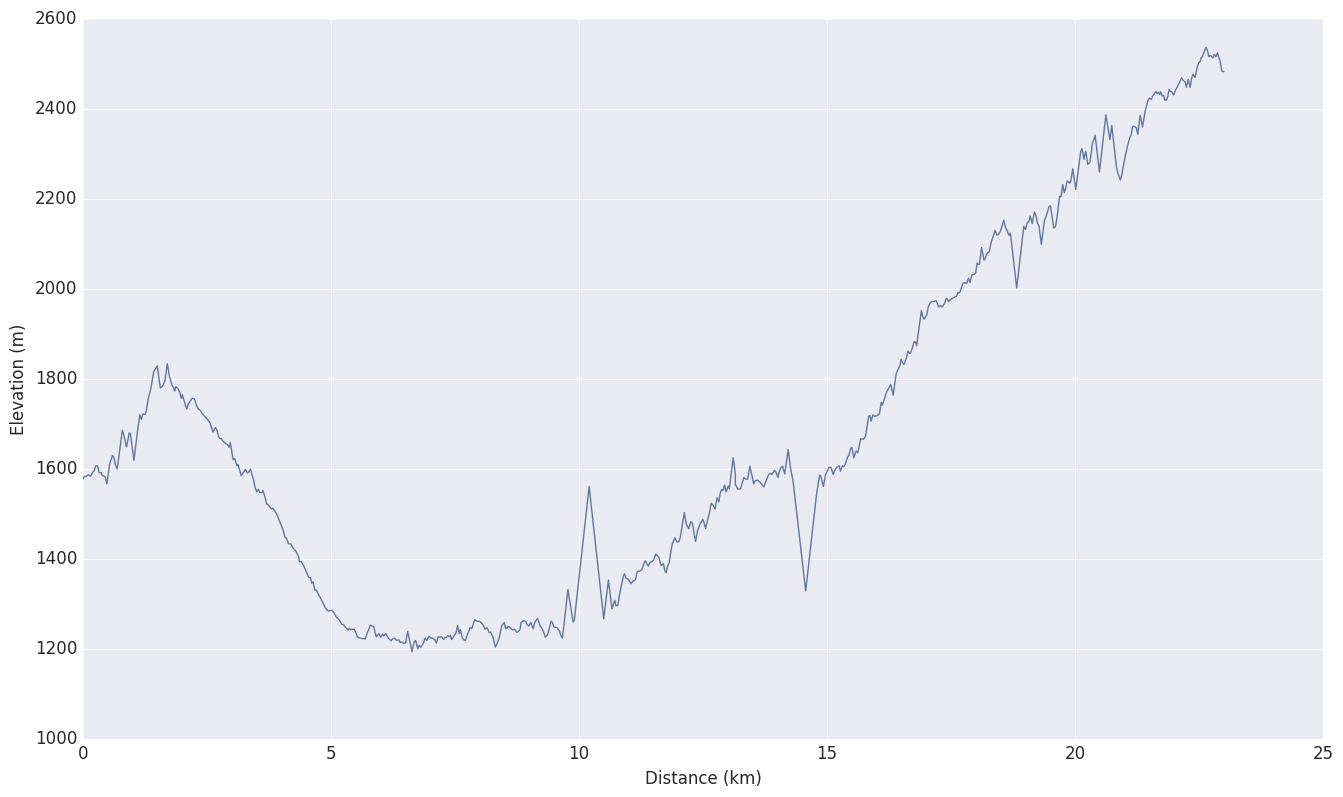

In [8]:
plot_day(2)

## Day 3: Refuge de la Croix de Bonhomme - Lake Miage

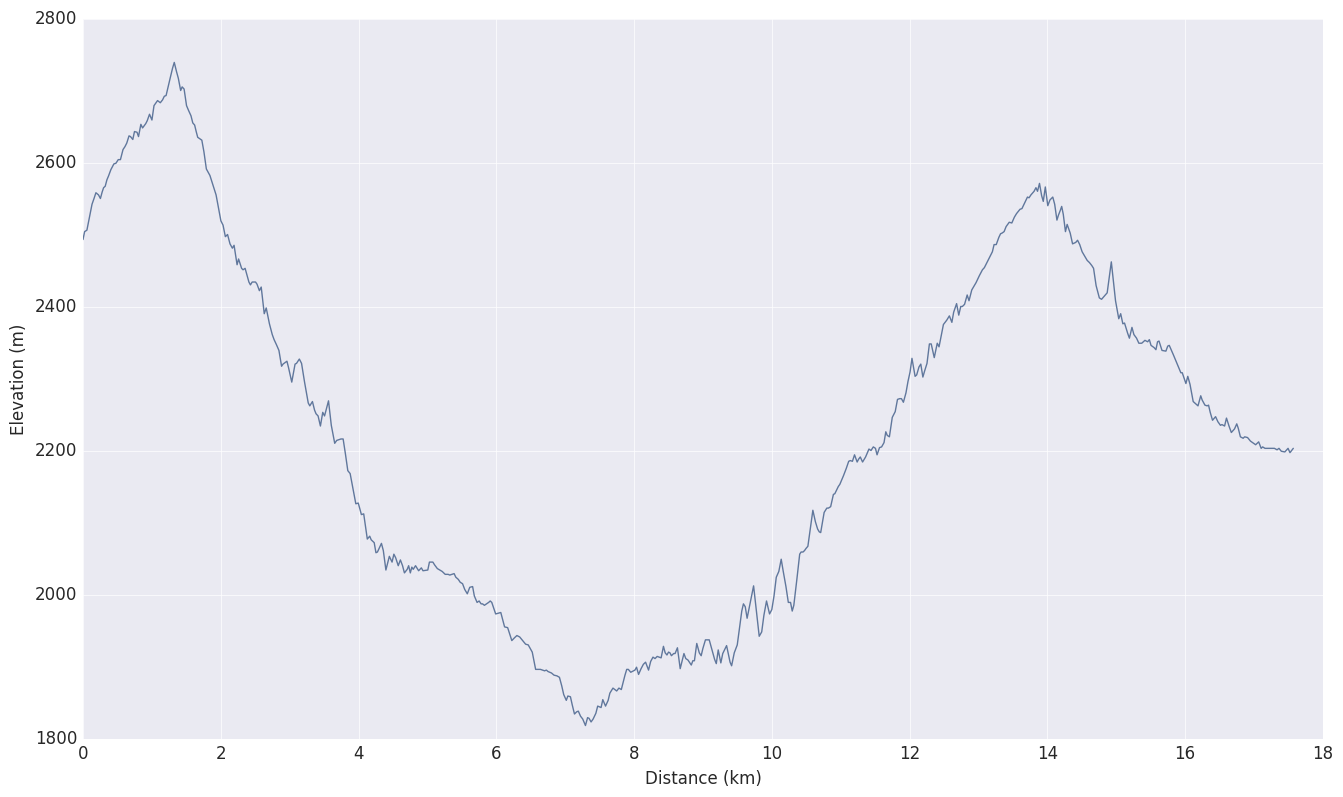

In [9]:
plot_day(3)

## Day 4: Lake Miage - Camping "La Sorgente" (Courmayeur)

The shortest day of the entire trip. We chose this day as the "rest" day and decided to stop at a camp site outside of Courmayeur, to get some comfort and visit the city.

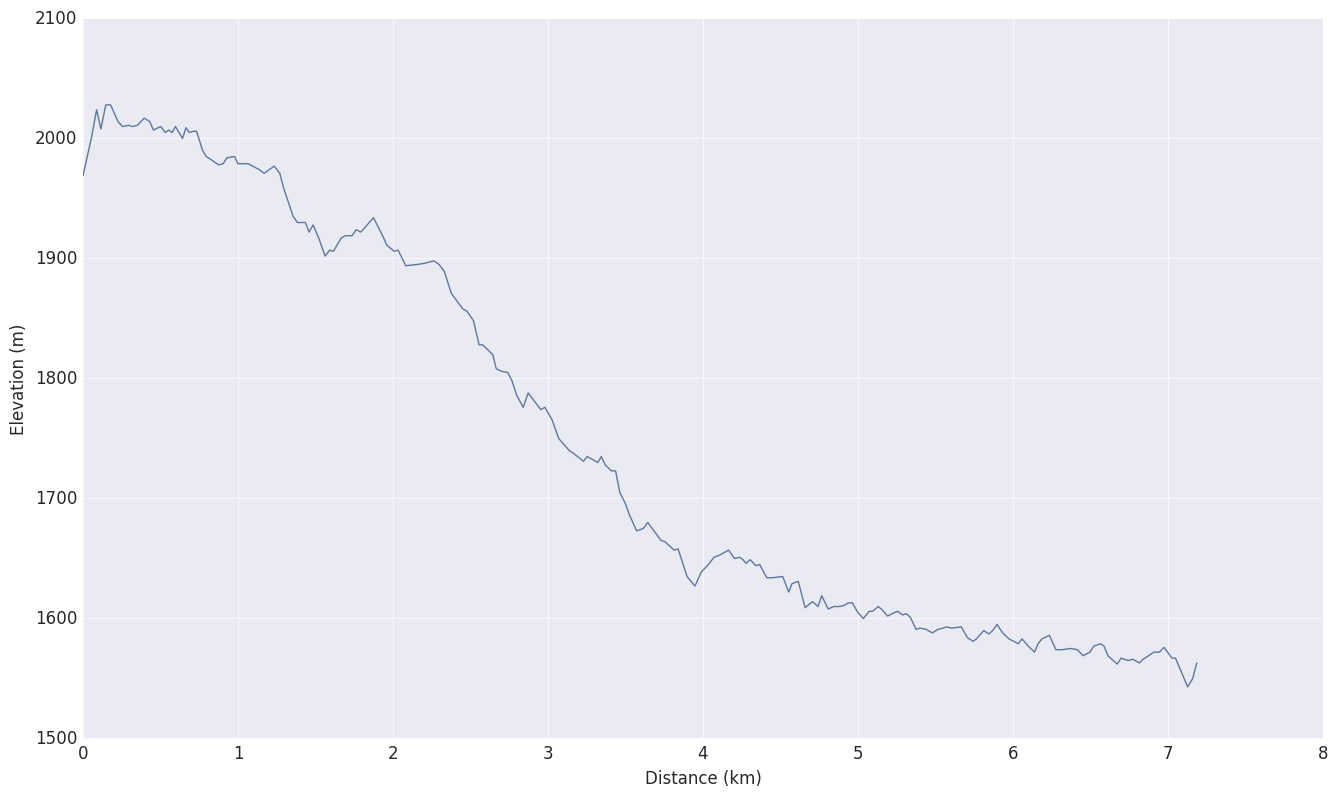

In [10]:
plot_day(4)

## Day 5: Camping "La Sorgente" - Chalet Val Ferret

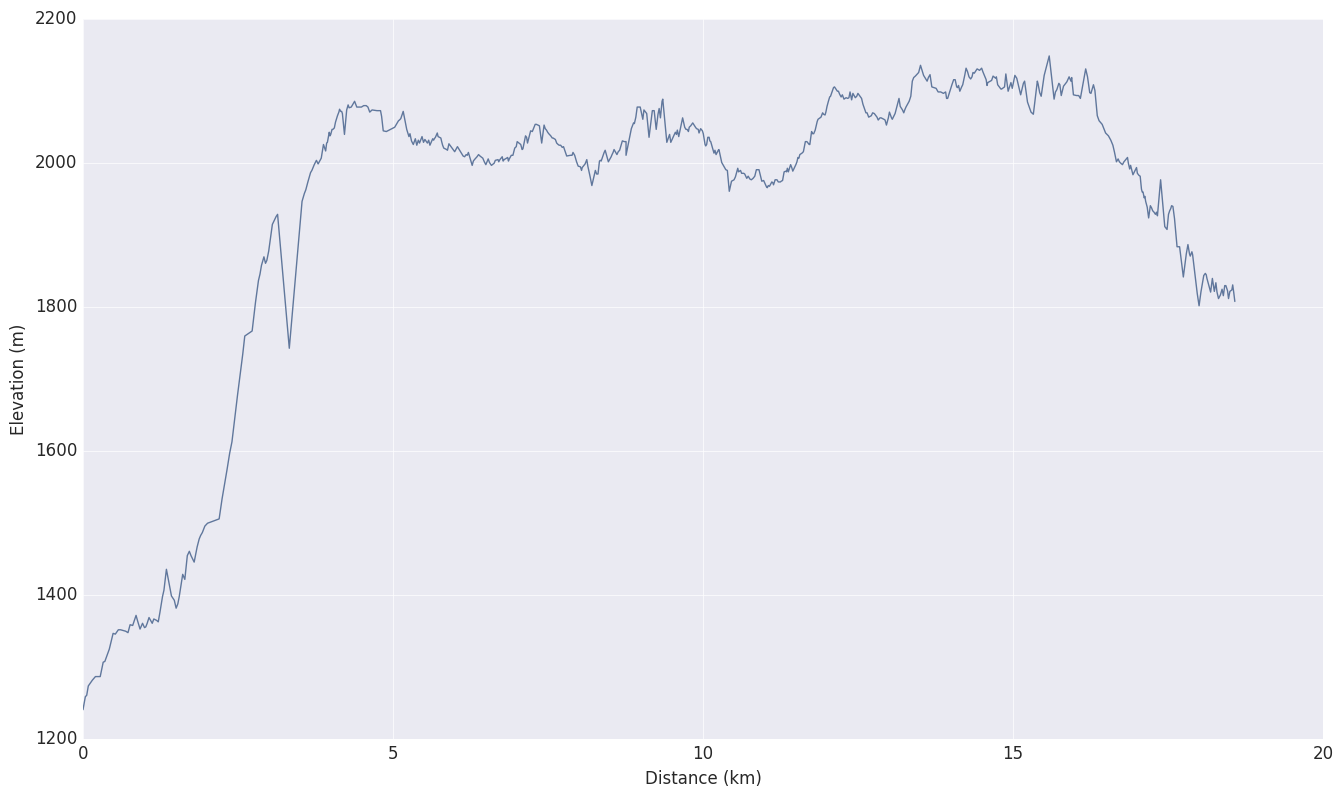

In [11]:
plot_day(5)

## Day 6: Chalet Val Ferret - Champex-Lac

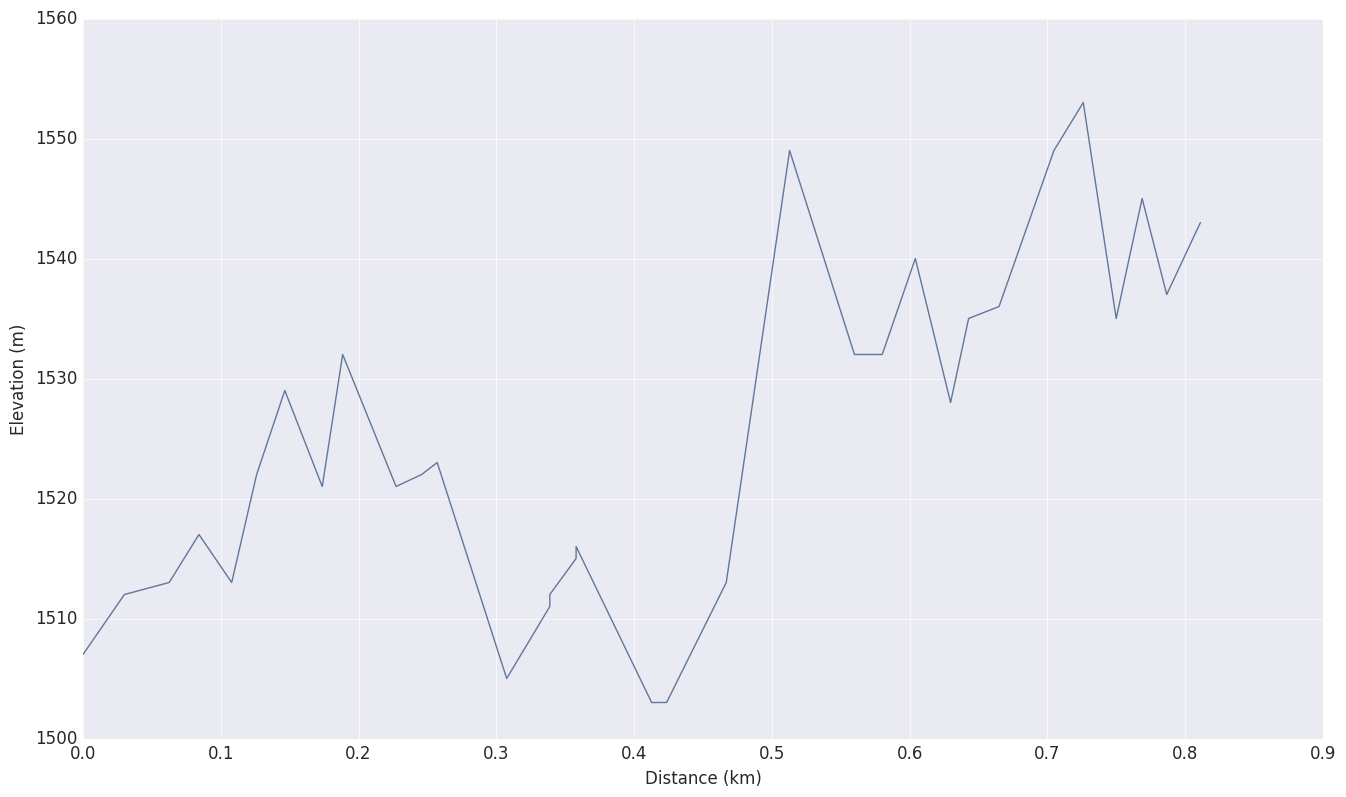

In [12]:
plot_day(6)

## Day 7: Champex-Lac - Col de la Forclaz

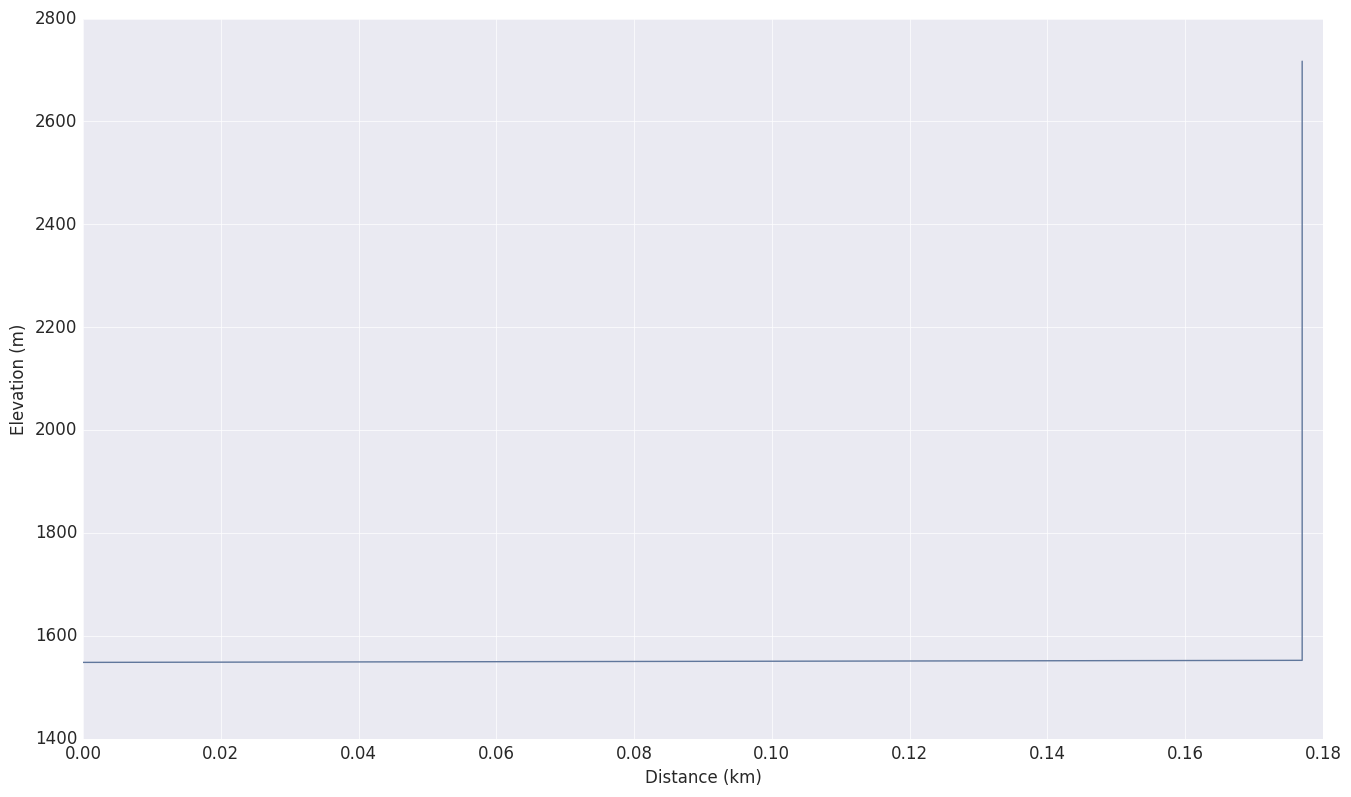

In [13]:
plot_day(7)

## Day 8: Col de la Forclaz - Argentiere

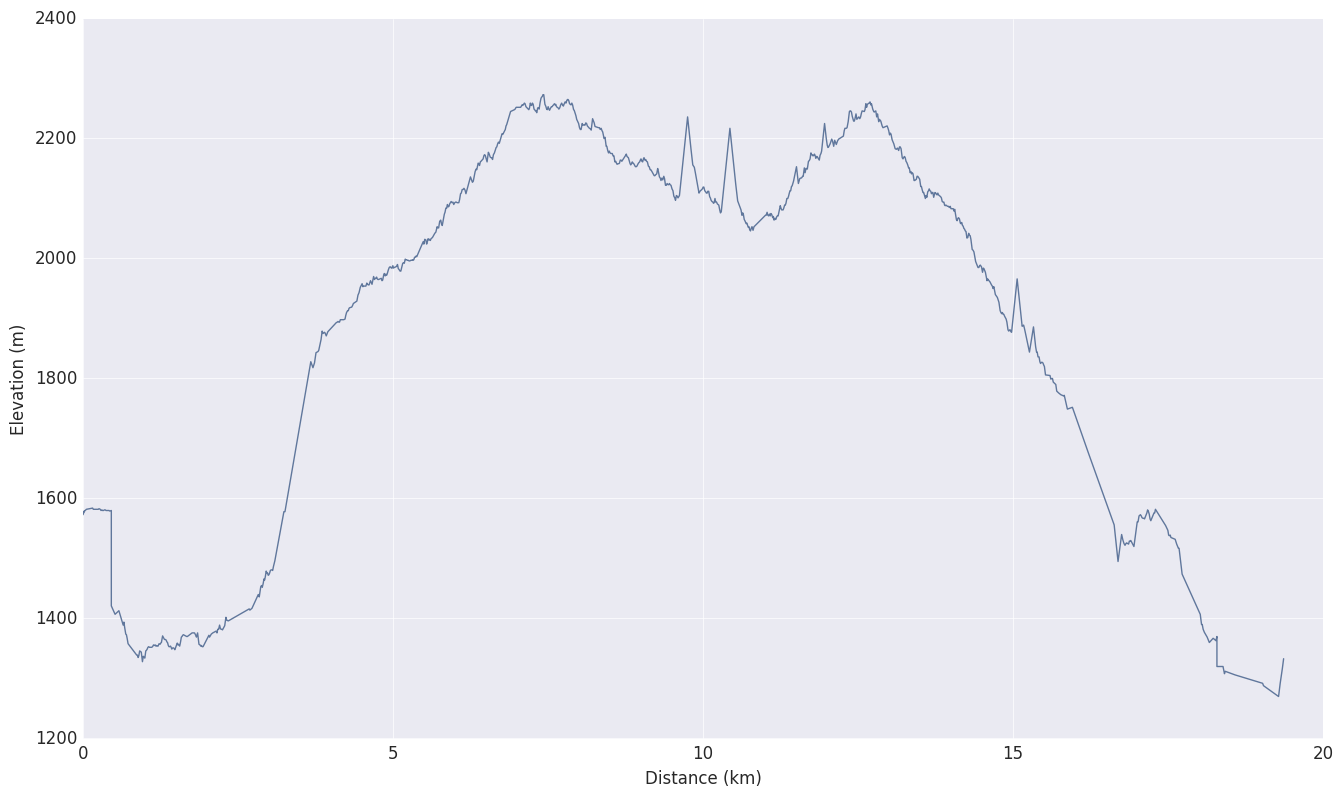

In [ ]:
plot_day(8)

## Day 9: Argentiere - Chamonix

Last day of the trip. We decided to finish in Chamonix instead of Les Houches. I have to say it's not the complete loop, but we had time constraints to respect (9 days) and chosed the saner option!

In [ ]:
plot_day(9)

## All In

In [ ]:
display(qgrid.show_grid(df))

## Final words

Again, Jupyter notebooks came handy. Combining the narration of the trip with statistics for each day is very easy to do with a notebook.

I hope this will help some trekkers going for the Tour du Mont Blanc. It's a great experience, highly recommended!

The approach used in this notebook can also be adapted to other trips or hikes of course.

Happy trekking and coding!